In [1]:
# change main root dir
%cd ..\..

D:\Projects\CondaAnalyses\PMI


In [2]:
import os
import gc
import numpy as np
import pandas as pd
import geopy
import geopandas as gpd
import seaborn as sns
from random import randint
from datetime import datetime
import matplotlib.pyplot as plt
import folium
import utilities
from functools import reduce
data_path = 'data_checkpoints/usecase_cab/'

In [3]:
base_df = pd.read_csv(data_path+'clean_cabspotting_df.csv', index_col=0)
origin_destination_df = pd.read_csv(data_path+'origin_destination_coordinates.csv', index_col=0)

dfs = [base_df,  origin_destination_df]

# merge dataframes
df = reduce(lambda  left,right:
            pd.merge(left, right, on=['id']),
            dfs)

# Keep RAM happy
del base_df, origin_destination_df, dfs
gc.collect()

df['time']= pd.to_datetime(df['time'])
df.head()

,id,file_name,latitude,longitude,time,occupancy,id_event,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude
0,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709
1,abboip_1211033614,abboip,37.75149,-122.39447,2008-05-17 14:13:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709
2,abboip_1211033674,abboip,37.75149,-122.39447,2008-05-17 14:14:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709
3,abboip_1211033735,abboip,37.75149,-122.39446,2008-05-17 14:15:35,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709
4,abboip_1211035303,abboip,37.75144,-122.39449,2008-05-17 14:41:43,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709


In [4]:
# Add immediate next events origin latitudes and longitudes 
df['next_event_origin_latitude'] = df.sort_values(['id', 'time'])['latitude'].shift(-1)
df['next_event_origin_longitude'] = df.sort_values(['id', 'time'])['longitude'].shift(-1)
df.head()

,id,file_name,latitude,longitude,time,occupancy,id_event,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude,next_event_origin_latitude,next_event_origin_longitude
0,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.75149,-122.39447
1,abboip_1211033614,abboip,37.75149,-122.39447,2008-05-17 14:13:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.75149,-122.39447
2,abboip_1211033674,abboip,37.75149,-122.39447,2008-05-17 14:14:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.75149,-122.39446
3,abboip_1211033735,abboip,37.75149,-122.39446,2008-05-17 14:15:35,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.75144,-122.39449
4,abboip_1211035303,abboip,37.75144,-122.39449,2008-05-17 14:41:43,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.75151,-122.39453


In [5]:
next_event_origin_latitude_df = df.sort_values(['time']).groupby('id_event').next_event_origin_latitude.last().to_frame().reset_index()
next_event_origin_longitude_df = df.sort_values(['time']).groupby('id_event').next_event_origin_longitude.last().to_frame().reset_index()

In [6]:
# Modify next event origin lat,lon based on occupancy state change
df = df.drop(['next_event_origin_latitude', 'next_event_origin_longitude'], axis=1)
df = pd.merge(df, next_event_origin_latitude_df, on='id_event')
df = pd.merge(df, next_event_origin_longitude_df, on='id_event')

del next_event_origin_latitude_df, next_event_origin_longitude_df
gc.collect()

df.head()

,id,file_name,latitude,longitude,time,occupancy,id_event,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude,next_event_origin_latitude,next_event_origin_longitude
0,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724
1,abboip_1211033614,abboip,37.75149,-122.39447,2008-05-17 14:13:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724
2,abboip_1211033674,abboip,37.75149,-122.39447,2008-05-17 14:14:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724
3,abboip_1211033735,abboip,37.75149,-122.39446,2008-05-17 14:15:35,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724
4,abboip_1211035303,abboip,37.75144,-122.39449,2008-05-17 14:41:43,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724


In [7]:
unnocupied_df = df[df['occupancy']==0].sort_values(['time']).groupby('id_event').first()
unnocupied_df

,id,file_name,latitude,longitude,time,occupancy,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude,next_event_origin_latitude,next_event_origin_longitude
id_event,,,,,,,,,,,,,,
abboip_1211033530,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724
abboip_1211036160,abboip_1211036160,abboip,37.75580,-122.41441,2008-05-17 14:56:00,0,0.815618,1315.0,37.75580,37.75053,-122.41441,-122.42086,37.75177,-122.43095
abboip_1211037710,abboip_1211037710,abboip,37.75177,-122.43095,2008-05-17 15:21:50,0,2.485586,1285.0,37.75177,37.77181,-122.43095,-122.41836,37.75240,-122.41842
abboip_1211042074,abboip_1211042074,abboip,37.79171,-122.41162,2008-05-17 16:34:34,0,1.706602,932.0,37.79171,37.80455,-122.41162,-122.42228,37.74670,-122.40395
abboip_1211045370,abboip_1211045370,abboip,37.74670,-122.40395,2008-05-17 17:29:30,0,1.134740,599.0,37.74670,37.75276,-122.40395,-122.41432,37.75267,-122.41427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uvreoipy_1213022171,uvreoipy_1213022171,uvreoipy,37.80522,-122.40697,2008-06-09 14:36:11,0,2.147797,1204.0,37.80522,37.80241,-122.40697,-122.43110,37.80305,-122.42995
uvreoipy_1213024205,uvreoipy_1213024205,uvreoipy,37.79833,-122.39855,2008-06-09 15:10:05,0,2.229112,542.0,37.79833,37.80299,-122.39855,-122.42317,37.80299,-122.42317
uvreoipy_1213025340,uvreoipy_1213025340,uvreoipy,37.79215,-122.40558,2008-06-09 15:29:00,0,2.663485,1022.0,37.79215,37.79623,-122.40558,-122.43538,37.79697,-122.43550


In [10]:
def get_h_distance(df):
    """
    Method to calculate Haversine distance of two coordinates. 
    http://project-osrm.org/docs/v5.5.1/api/#general-options
    """
    
    coords_start = (df['destination_latitude'], df['destination_longitude'])
    coords_end = (df['next_event_origin_latitude'], df['next_event_origin_longitude'])
    
    h_distance = geopy.distance.distance(coords_start, coords_end).kilometers
    
    return h_distance


error_distance = unnocupied_df[['destination_latitude', 'destination_longitude', 'next_event_origin_latitude', 'next_event_origin_longitude']].apply(get_h_distance, axis=1)

In [11]:
# km
mse = sum(error_distance*error_distance)/len(error_distance)
print(f'The mean squared error is: {mse}')

The mean squared error is: 1.577255465239175


In [9]:
# miles
mse = sum(error_distance*error_distance)/len(error_distance)
print(f'The mean squared error is: {mse}')

The mean squared error is: 0.6089817397017229


In [12]:
del error_distance, unnocupied_df
gc.collect()

0

In [15]:
# Decomposing time to explore taxi occupancy
df['week_day'] = df['time'].dt.dayofweek
df['hour'] = df['time'].dt.hour
df.head()

,id,file_name,latitude,longitude,time,occupancy,id_event,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude,next_event_origin_latitude,next_event_origin_longitude,week_day,hour
0,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14
1,abboip_1211033614,abboip,37.75149,-122.39447,2008-05-17 14:13:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14
2,abboip_1211033674,abboip,37.75149,-122.39447,2008-05-17 14:14:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14
3,abboip_1211033735,abboip,37.75149,-122.39446,2008-05-17 14:15:35,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14
4,abboip_1211035303,abboip,37.75144,-122.39449,2008-05-17 14:41:43,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14


In [16]:
time_groups = df.sort_values(['time']).groupby(by=['id_event']).hour
event_start_hour = time_groups.first().to_frame()
event_end_hour = time_groups.last().to_frame()

In [17]:
# bin hours

def bin_hour(val):
    if 6 < val < 12:
        return "morning"
    elif 12 < val < 18:
        return "afternoon"
    elif 18 < val < 24:
        return "night"
    else:
        return "late"
    
time_bin_event_start = event_start_hour['hour'].apply(bin_hour).to_frame().rename(columns={'hour': 'start_time_of_day'})
time_bin_event_end = event_start_hour['hour'].apply(bin_hour).to_frame().rename(columns={'hour': 'end_time_of_day'})

In [20]:
df = pd.merge(df, time_bin_event_start.reset_index(), on="id_event")
df = pd.merge(df, time_bin_event_end.reset_index(), on="id_event")
df.head()

,id,file_name,latitude,longitude,time,occupancy,id_event,travelled_distance_km,event_duration,origin_latitude,destination_latitude,origin_longitude,destination_longitude,next_event_origin_latitude,next_event_origin_longitude,week_day,hour,start_time_of_day,end_time_of_day
0,abboip_1211033530,abboip,37.75153,-122.39447,2008-05-17 14:12:10,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14,afternoon,afternoon
1,abboip_1211033614,abboip,37.75149,-122.39447,2008-05-17 14:13:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14,afternoon,afternoon
2,abboip_1211033674,abboip,37.75149,-122.39447,2008-05-17 14:14:34,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14,afternoon,afternoon
3,abboip_1211033735,abboip,37.75149,-122.39446,2008-05-17 14:15:35,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14,afternoon,afternoon
4,abboip_1211035303,abboip,37.75144,-122.39449,2008-05-17 14:41:43,0,abboip_1211033530,0.301731,2314.0,37.75153,37.74978,-122.39447,-122.39709,37.74977,-122.39724,5,14,afternoon,afternoon


In [21]:
del time_bin_event_start, time_bin_event_end
gc.collect()

831

In [22]:
event_df = df.sort_values(['time']).groupby(by=['id_event']).first()

<AxesSubplot:title={'center':'Duration of event: Day of Week'}, xlabel='week_day', ylabel='event_duration'>

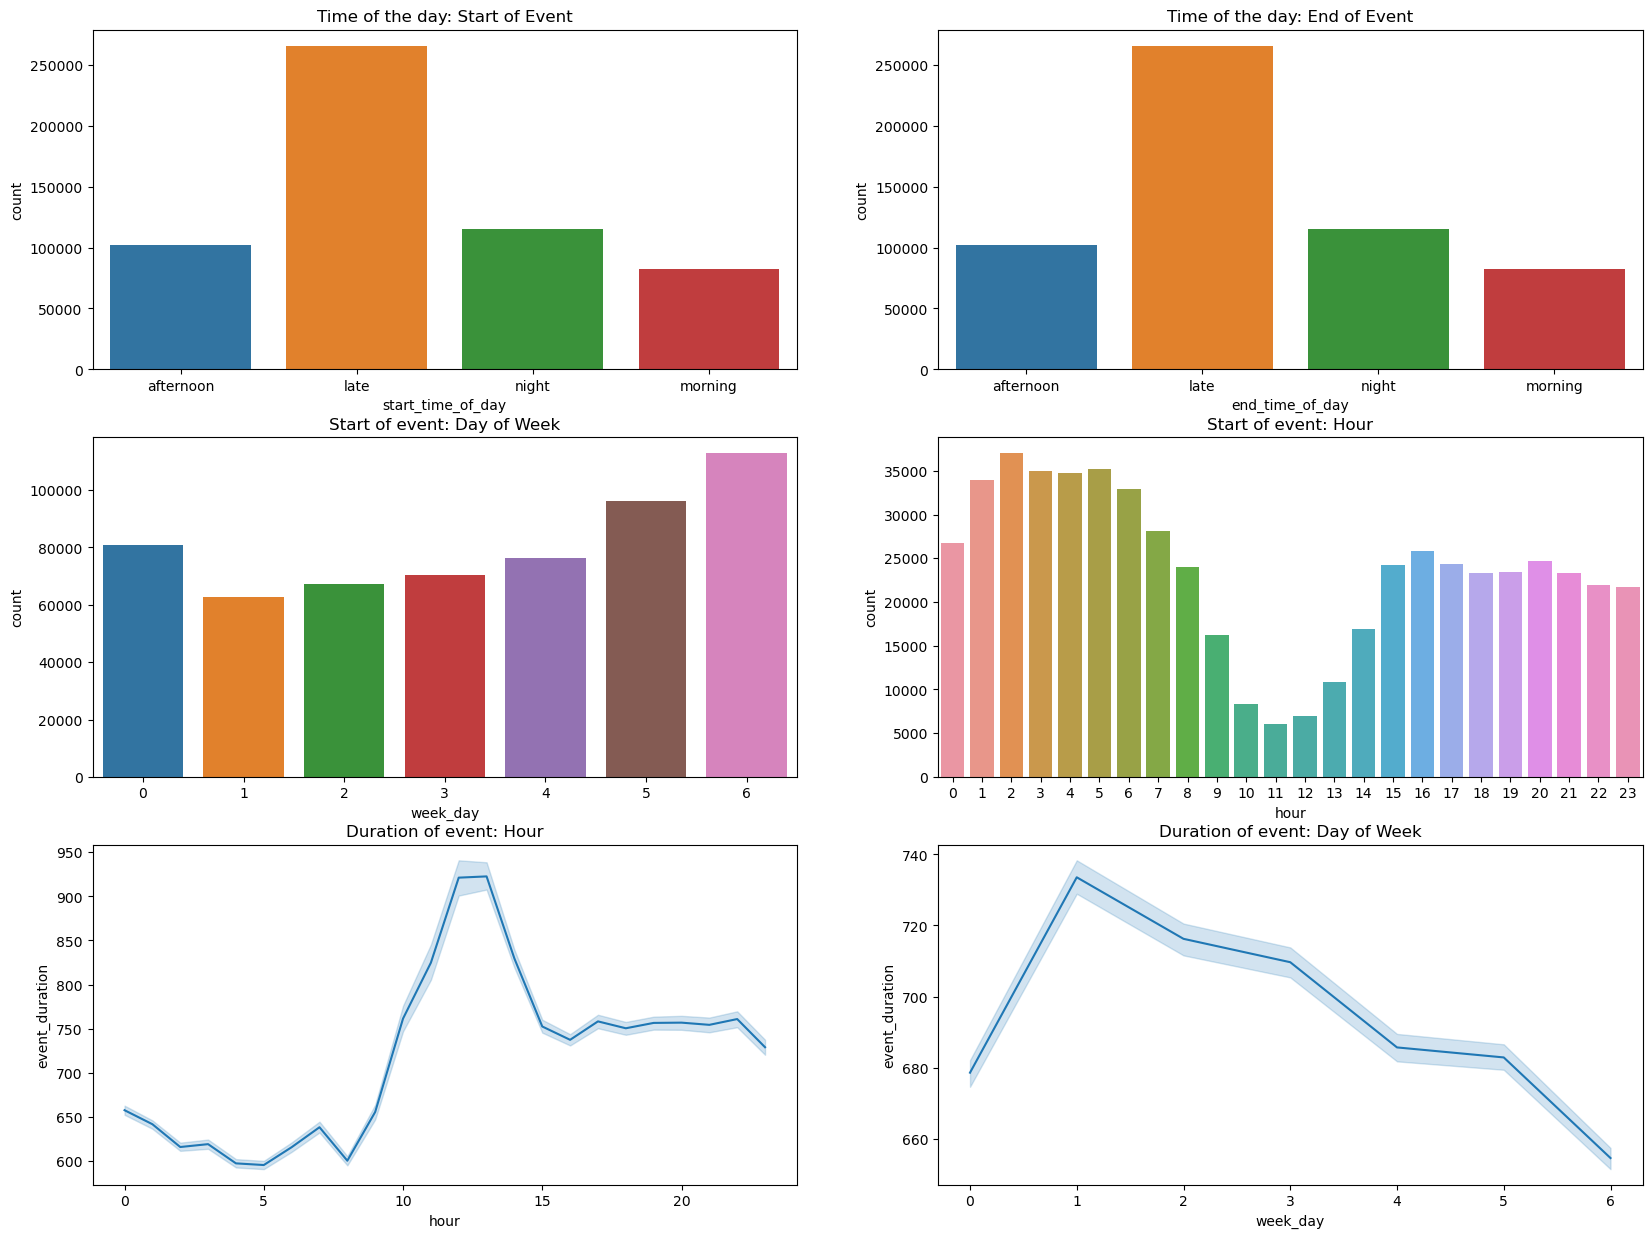

In [25]:
figure, axs = plt.subplots(3, 2, figsize=(20, 15))

axs[0, 0].set_title('Time of the day: Start of Event')
sns.countplot(x="start_time_of_day" ,data=event_df, ax=axs[0, 0])

axs[0, 1].set_title('Time of the day: End of Event')
sns.countplot(x="end_time_of_day" ,data=event_df, ax=axs[0, 1])

axs[1, 0].set_title('Start of event: Day of Week')
sns.countplot(x="week_day" ,data=event_df, ax=axs[1, 0])

axs[1, 1].set_title('Start of event: Hour')
sns.countplot(x="hour" ,data=event_df, ax=axs[1, 1])

axs[2, 0].set_title('Duration of event: Hour')
sns.lineplot(data=event_df, x='hour', y='event_duration', ax=axs[2, 0])

axs[2, 1].set_title('Duration of event: Day of Week')
sns.lineplot(data=event_df, x='week_day', y='event_duration', ax=axs[2, 1])

In [26]:
empty_cab_event_df = event_df[event_df.occupancy == 0]
full_cab_event_df = event_df[event_df.occupancy == 1]

In [28]:
from sklearn.cluster import KMeans

In [1]:
pickup_cluster = full_cab_event_df[['origin_latitude', 'origin_longitude']].reset_index(drop=True)
Ks = range(1, 10)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(pickup_cluster).score(pickup_cluster) for i in range(len(km))]

NameError: name 'full_cab_event_df' is not defined

<AxesSubplot:xlabel='origin_longitude', ylabel='origin_latitude'>

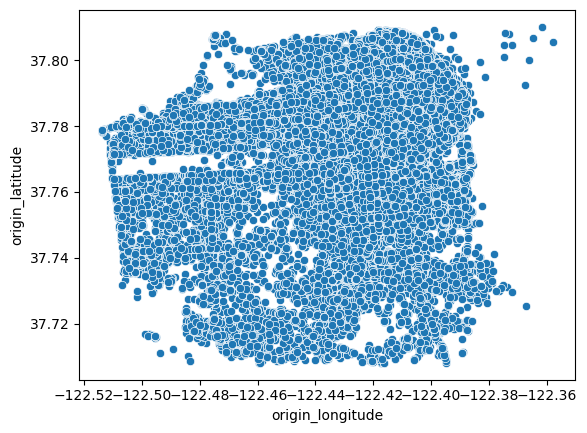

In [33]:
# Checking once again: 
sns.scatterplot(x=pickup_cluster['origin_longitude'], y=pickup_cluster['origin_latitude'])

Text(0, 0.5, 'Events per Cluster')

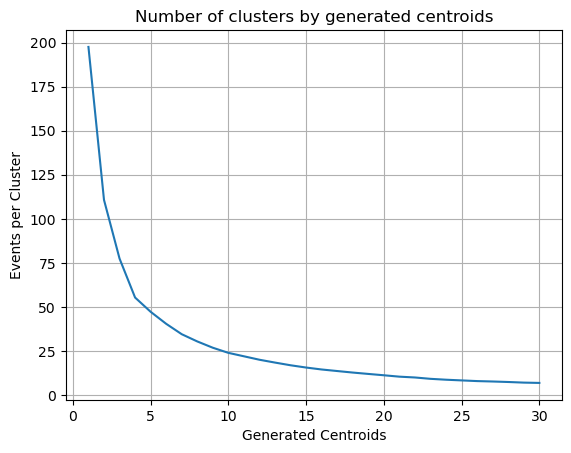

In [67]:
## Find how many centroids make sense to apply kmeans
clusters = []
for i in range(1, 31):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pickup_cluster)
    clusters.append(kmeans.inertia_)

fig = plt.figure()
plt.plot(range(1, 31), clusters)
plt.grid(True)
plt.title('Number of clusters by generated centroids')
plt.xlabel('Generated Centroids')
plt.ylabel('Events per Cluster')

In [35]:
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans.fit(pickup_cluster)
centroids = kmeans.cluster_centers_

In [58]:
# Plotting the centroids on google map using Folium library.
SFO_COORDSINATES = 37.733795, -122.446747

map = folium.Map(location=[SFO_COORDSINATES[0], SFO_COORDSINATES[1]], zoom_start = 10)
folium.Marker([SFO_COORDSINATES[0], SFO_COORDSINATES[1]]).add_to(map)
for centroid in centroids: 
    folium.Marker([centroid[0], centroid[1]], icon=folium.Icon(color="orange", icon="arrow-down")).add_to(map)
map